In [1]:
import os
import random
import warnings
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorly.decomposition import tucker
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


from data import collect_data
from calc import *
from plot_data import *


In [2]:
df = np.load('xyz_acc.npy', allow_pickle =True) #np.load('series.npy', allow_pickle=True)
df = pd.DataFrame(df, columns = [str(i) for i in np.arange(2950)]+ ['Axis','UserID', 'Activity', 'Device'])
df.drop(df[(df.Device==1) & (df.UserID==1607) & (df.Activity=='J')].index[0], inplace = True)
df.drop(df[(df.Device==1) & (df.UserID==1609) & (df.Activity=='B')].index[0], inplace = True)
df.drop(df[(df.Device==1) & (df.UserID==1616) & (df.Activity=='F')].index[0], inplace = True)
df.drop(df[(df.Device==0) & (df.UserID==1637) & (df.Activity=='J')].index[0], inplace = True)
df.drop(df[(df.Device==0) & (df.UserID==1639) & (df.Activity=='L')].index[0], inplace = True)
df.drop(df[(df.Device==1) & (df.UserID==1643) & (df.Activity=='I')].index[0], inplace = True)

In [3]:
new_rows = []

for i, row in tqdm(df.iterrows()):
    for j in range(14):  # 2800 / 200 = 14
        new_row = row[j*200:(j+1)*200].tolist()
        new_row.extend(row[['Axis', 'UserID', 'Activity', 'Device']])
        new_rows.append(new_row)

new_df = pd.DataFrame(new_rows, columns=[f'val_{i}' for i in range(200)] + ['Axis', 'UserID', 'Activity', 'Device'])


In [4]:
df = pd.DataFrame(new_rows, columns=[f'val_{i}' for i in range(200)] + ['Axis', 'UserID', 'Activity', 'Device'])
scaler = MinMaxScaler()
df[df.columns[0:200]] = scaler.fit_transform(df[df.columns[0:200]])

In [5]:
N_FEATURES = 200
N_CH = 3
qpfs_feat_nums = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 0]

ticks_array = np.array(np.array([5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200])/2).astype(int)


kf_params = {'n_splits': 5,
            'shuffle': True,
            'random_state': 42}

riemann_params = {
    'n_features': 6,
    'hidden_sizes': [16, 32, 64],
    'dropout': 0.4,
    'learning_rate': 0.01,
    'n_epochs': 20,
    'batch_size': 256
}

custom_model_params = {
    'n_ch': N_CH,
    'n_features': N_FEATURES,
    'hidden_sizes': [512, 256, 512, 1024, 2048, 1024],
    'dropout': 0.5,
    'learning_rate': 1e-3,
    'n_epochs': 20,
    'batch_size': 256
}

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [6]:
X_tensor, smart_indexes, watch_indexes = collect_data(df, N_FEATURES, N_CH)


In [7]:
last_index = np.nonzero(X_tensor)[0][-1] if np.nonzero(X_tensor)[0][-1] % 2==0 else np.nonzero(X_tensor)[0][-1]-1

X_tensor = X_tensor[:last_index]
X_tensor_old = X_tensor.copy()

In [13]:
exp_ae_res = aeCrossVal(qpfs_feat, qpfs_feat_nums, X_tensor, X_tensor_old, smart_indexes[:-2], watch_indexes[:-2], DEVICE)
exp_r_res = riem_main(qpfs_feat, qpfs_feat_nums, X_tensor, X_tensor_old, riemann_params, custom_model_params, DEVICE)


In [25]:
exp_r_res = np.load('riem_res.npy', allow_pickle=True)
exp_ae_res = np.load('ae_res.npy', allow_pickle=True)

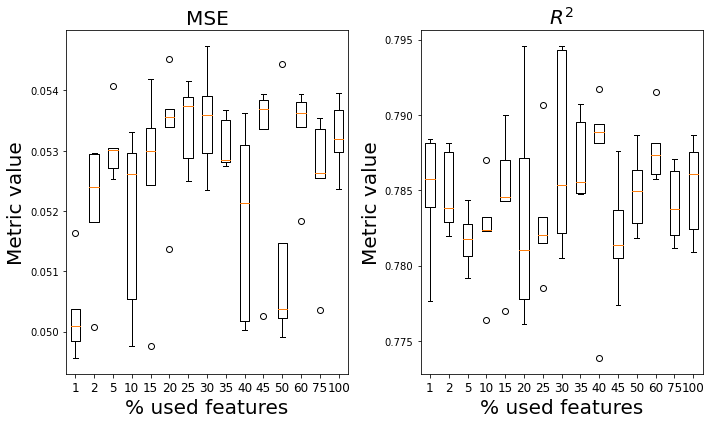

In [26]:
plot_metrics(exp_ae_res, ticks_array)

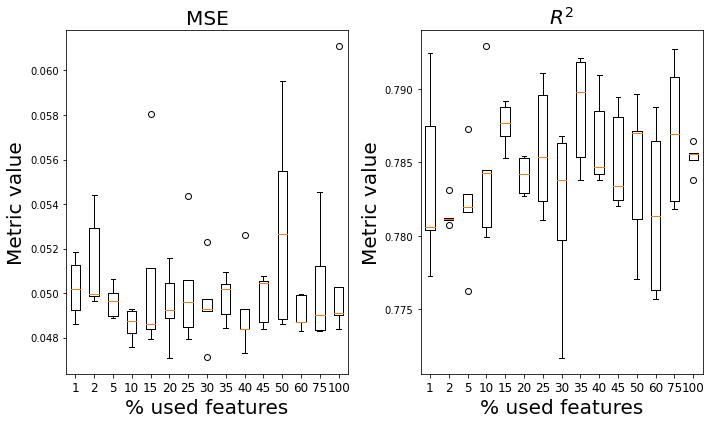

In [27]:
plot_boxplots(exp_r_res, ticks_array)